## TGS Saltbody Detection (Kaggle)
Predict saltbody on multiple 2D seismic images by U-Net

### Import Libraries

In [1]:
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imageio
import copy
import tensorflow as tf
from keras import backend as K
from keras import Input,optimizers
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
from keras_tqdm import TQDMNotebookCallback
from sklearn.model_selection import train_test_split
from skimage.transform import resize

Using TensorFlow backend.


### Data Loading

In [2]:
path_data = os.getcwd() + '/dataset'
path_train_img = path_data + '/train/images/'
path_train_msk = path_data + '/train/masks/'
path_test_img = path_data + '/test/'
train = pd.read_csv(path_data + '/train.csv')
sample_submit = pd.read_csv(path_data + '/sample_submission.csv')

size_img = 101
size_img_target = 128
num_epoch = 50
num_batch = 32

In [3]:
def load_images(size_img,path_img,path_msk=[]):
    ''' Load image files into memory '''
    flatten_msk = lambda x: list(map(int,np.reshape(x,np.size(x,0)*np.size(x,1))))
    numimgs = len([name for name in os.listdir(path_img) if name.endswith('.png')])
    i = 0
    ids = []
    data_img = np.zeros([numimgs,size_img,size_img])
    data_msk = np.zeros([numimgs,size_img,size_img])
    
    for file in os.listdir(path_img):
        if file.endswith('.png'):
            id_tmp = file[:-4]
            ids.append(id_tmp)
            data_img[i,:,:] = np.array(list(zip(*imageio.imread(path_img + file)[:,:,0]/255)))
            if path_msk:                
                msk = flatten_msk(list(zip(*imageio.imread(path_msk + file))))
                msk = [1 if i > 0 else 0 for i in msk]
                data_msk[i,:,:] = np.array(msk).reshape([size_img,size_img])
            i += 1
    return ids,data_img,data_msk

In [4]:
ids_train,data_img,data_msk = load_images(size_img,path_train_img,path_train_msk)
ids_test, test_img, _ = load_images(size_img,path_test_img)

<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Data Preprocessing (Upsampling)

In [5]:
def upsample(img):
    ''' Upsample raw images from 101 x 101 to 128 x 128 '''
    if size_img == size_img_target:
        return img
    return resize(img, (size_img_target, size_img_target), mode='constant', preserve_range=True)

util_upsample = lambda data: np.array(list(map(upsample,data))).reshape(-1,size_img_target,size_img_target,1)

In [6]:
data_img_up = util_upsample(data_img)
data_msk_up = util_upsample(data_msk)
test_img_up = util_upsample(test_img)
x_train = np.append(data_img_up, [np.fliplr(x) for x in data_img_up], axis=0)
y_train = np.append(data_msk_up, [np.fliplr(x) for x in data_msk_up], axis=0)
im_train,im_val,lb_train,lb_val=train_test_split(x_train,y_train,test_size=0.2,random_state=42)

### Model Metrics

In [7]:
def dice_loss(y_true, y_pred):
    ''' Dice Loss function '''
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

In [8]:
def bce_dice_loss(y_true, y_pred):
    ''' Binary Cross Entropy (BCE) Dice Loss function '''
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

### Model (U-Net)

In [9]:
def Conv2d_with_prm(model_in, num_filters):
    ''' Wrapper for Conv2D function '''
    conv = Conv2D(filters=num_filters,
                  kernel_size=(3,3),
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(model_in)
    return conv

In [10]:
def conv2d_down(model_in, num_filters, pooling=False, dropout=False):
    ''' Downward part for U-Net '''
    drop = []
    pool = []
    conv = Conv2d_with_prm(model_in, num_filters)
    conv = Conv2d_with_prm(conv, num_filters)
    if dropout:
        drop = Dropout(rate=0.5)(conv)
    if pooling:
        pool = MaxPooling2D(pool_size=(2, 2))(conv)
    return conv, drop, pool

In [11]:
def conv2d_up(model_in, model_merge, num_filters):
    ''' Upward part for U-Net '''
    up = Conv2d_with_prm(UpSampling2D(size=(2,2))(model_in) , num_filters)     
    merge = concatenate([model_merge, up], axis=3)
    conv = Conv2d_with_prm(merge, num_filters)
    conv = Conv2d_with_prm(conv, num_filters)        
    return conv, up, merge

In [12]:
def visualize_model(self, path_savefig='model_plot.png'):
    ''' Summarize and visualize created U-Net model '''
    self.model.summary()
    plot_model(self.model, to_file=path_savefig, show_shapes=True, show_layer_names=True)

In [13]:
def unet(input_size,lr=1e-4):
    ''' Compile U-Net Model '''
    inputs = Input(input_size)
    conv1, _, pool1 = conv2d_down(inputs, 2**4, pooling=True)
    conv2, _, pool2 = conv2d_down(pool1,  2**5, pooling=True)
    conv3, _, pool3 = conv2d_down(pool2,  2**6, pooling=True)
    _, drop4, pool4 = conv2d_down(pool3,  2**7, pooling=True, dropout=True)
    _, drop5, _ = conv2d_down(pool4,  2**8, pooling=False, dropout=True)
    conv6, _, _ = conv2d_up(drop5, drop4, 2**7)
    conv7, _, _ = conv2d_up(conv6, conv3, 2**6)
    conv8, _, _ = conv2d_up(conv7, conv2, 2**5)
    conv9, _, _ = conv2d_up(conv8, conv1, 2**4)   
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    model = Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer=optimizers.Adam(lr),loss=bce_dice_loss, metrics=['acc'])
    return model

In [ ]:
tf.logging.set_verbosity(tf.logging.ERROR)
model = unet((size_img_target,size_img_target,1),lr=1e-3)
early_stopping = EarlyStopping(patience=10, verbose=0)
model_checkpoint = ModelCheckpoint('./keras.model', save_best_only=True, verbose=0)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)

tic = time.time()
history = model.fit(im_train,lb_train,batch_size=num_batch,epochs=num_epoch,
                    validation_data=(im_val,lb_val),verbose=0,shuffle=True,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr, TQDMNotebookCallback()])
toc = time.time()

In [15]:
print('Comutation time: ' + '{:1.1f}'.format((toc - tic)/60) + ' min')

Comutation time: 9.2 min


### Training Metrics for every epoch

In [16]:
def plot_acc_epoch(acc,val_acc,loss,val_loss):
    ''' Plot accuracy and loss for training and validation data '''

    # Accuracy
    epochs = range(1,len(acc) + 1)
    plt.subplots(1, 2, figsize=(12, 5))
    ax1 = plt.subplot(121)
    plt.plot(epochs,acc,'b',linewidth=1.5,label='Training acc')
    plt.plot(epochs,val_acc,'r',linewidth=1.5,label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    ax1.set_ylim([0.7,1])
    plt.legend(loc='lower right')

    # Loss
    ax2 = plt.subplot(122)
    plt.plot(epochs,loss,'b',linewidth=1.5,label='Training loss')
    plt.plot(epochs,val_loss,'r',linewidth=1.5,label='Validation loss')
    plt.title('Training and validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

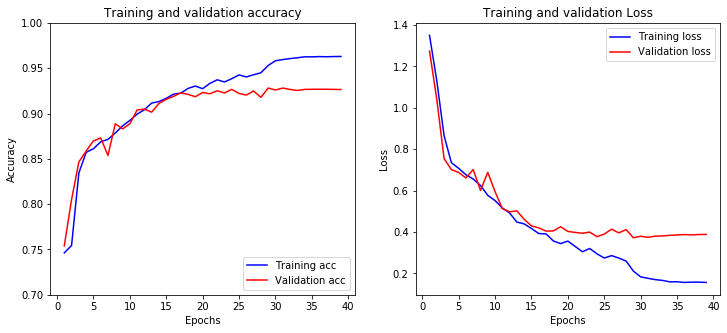

In [18]:
plot_acc_epoch(acc,val_acc,loss,val_loss)

### Visualize some of the trained weights

In [19]:
def deprocess_image(x):
    ''' Utility function to convert a tensor into a valid image '''
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [20]:
def generate_pattern(model, layer_output, filter_index, size):
    ''' Function to generate filter visualizations '''
    loss = K.mean(layer_output[:,:,:,filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1,size,size,1)) * 20 + 128
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return np.reshape(deprocess_image(img),[size,size])

In [21]:
def plt_filter_patterns(model, layer_name):
    ''' Plot filter pattens '''
    layer_output = model.get_layer(layer_name).output
    size = layer_output.get_shape().as_list()[1]
    margin = int(5 - np.log2(128/size))
    results = np.zeros((2*size + 1*margin, 8*size + 7*margin))
    for i in range(2):
        for j in range(8):
            filter_img = generate_pattern(model,layer_output, j + (i * 8) , size)
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,vertical_start:vertical_end] = filter_img.T
    
    plt.figure(figsize=(14,8))
    plt.imshow(results,cmap='gray')
    plt.title(layer_name)
    plt.tick_params(axis='both',which='both',bottom=False,left=False,labelleft=False,labelbottom=False)
    plt.show()

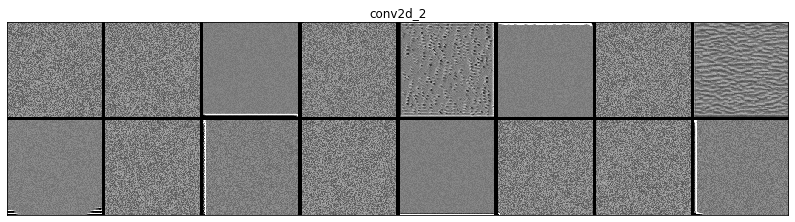

In [22]:
plt_filter_patterns(model,'conv2d_2') # 128 x 128 (downward conv2d)

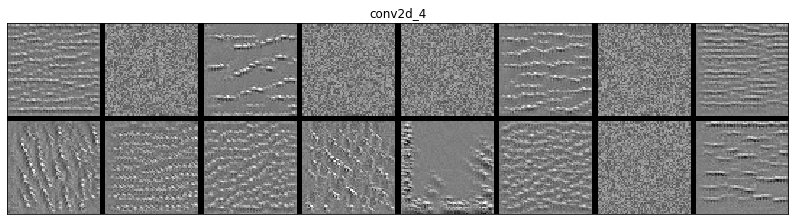

In [23]:
plt_filter_patterns(model,'conv2d_4') # 64 x 64 (downward conv2d)

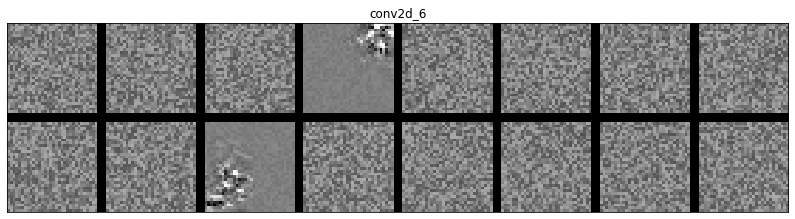

In [24]:
plt_filter_patterns(model,'conv2d_6') # 32 x 32 (downward conv2d)

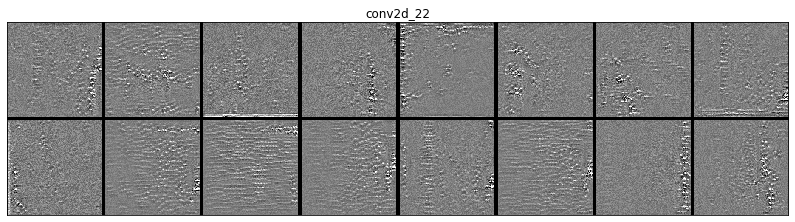

In [25]:
plt_filter_patterns(model,'conv2d_22') # 128 x 128 (upward conv2d)

### Prediction & Down sampling

In [26]:
def downsample(img):
    ''' Downsample images from 128 x 128 to 100 x 100 '''
    if size_img == size_img_target:
        return img
    return resize(img, (size_img, size_img), mode='constant', preserve_range=True)

util_downsample = lambda im: np.array([downsample(x) for x in im])

In [27]:
lb_pred_data = util_downsample(model.predict(data_img_up))
lb_pred_train = util_downsample(model.predict(im_train))
lb_orig_train = util_downsample(lb_train)
lb_pred_val = util_downsample(model.predict(im_val))
lb_orig_val = util_downsample(lb_val)
lb_pred_test = util_downsample(model.predict(test_img_up))

### Find optimal threshold based on IoU

In [28]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    ''' Function to calculate Intersection of Intersection of Union (IoU) '''
    labels = y_true_in
    y_pred = y_pred_in
    true_objects = 2
    pred_objects = 2
    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print('Thresh\tTP\tFP\tFN\tPrec.')
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print('{:1.3f}\t{}\t{}\t{}\t{:1.3f}'.format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print('AP\t-\t-\t-\t{:1.3f}'.format(np.mean(prec)))
    return np.mean(prec)

In [29]:
def precision_at(threshold, iou):
    ''' Calculate True Positive/False Positive/False Negative '''
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

In [30]:
def iou_metric_batch(y_true_in, y_pred_in):
    ''' Wrapper for IoU calculatoin '''
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [31]:
def plot_threshold_IoU(thresholds, ious, threshold_best, iou_best):
    ''' Plot IoU vs threshold '''
    fig,ax = plt.subplots(figsize=(7,4))
    plt.plot(thresholds, ious)
    plt.plot(threshold_best, iou_best, 'xr', label='Best threshold')
    plt.xlabel('Threshold',fontsize=12)
    plt.ylabel('IoU',fontsize=12)
    plt.title('Threshold vs IoU ({:.3f}, {:.3f})'.format(threshold_best, iou_best),fontsize=12)
    plt.legend(fontsize=10,loc='lower right')
    ax.tick_params(labelsize=12)
    plt.show()

In [32]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(lb_orig_val, np.int32(lb_pred_val > x)) for x in thresholds])
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

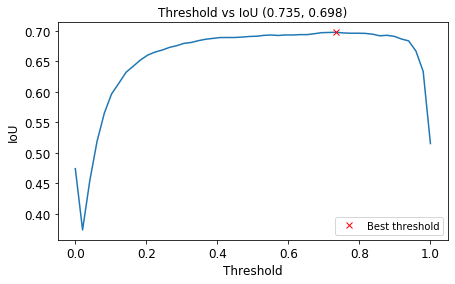

In [33]:
plot_threshold_IoU(thresholds, ious, threshold_best, iou_best)

### Show some results

In [34]:
def id2str(ids_pred):
    ''' Convert index of a mask image into a series of numbers '''
    output = []
    conseq = 1    
    for i in range(len(ids_pred)):
        if i == 0:
            output.append(ids_pred[i])
            if i == len(ids_pred) - 1:
                output.append(conseq)
        elif i == len(ids_pred) - 1:
            if ids_pred[i] - ids_pred[i-1] == 1:
                conseq += 1
            else:
                conseq = 1
            output.append(conseq)
        else:
            if ids_pred[i] - ids_pred[i-1] == 1:
                conseq += 1
            else:
                output.append(conseq)
                output.append(ids_pred[i])
                conseq = 1
    return output

In [35]:
def ids_output(y_pred,threshold):
    ''' Convert a saltbody probability image into index '''
    y_label = copy.deepcopy(y_pred)
    y_label[y_label > threshold] = 1
    y_label[y_label <= threshold] = 0
    ids_pred = np.where(np.array([int(i) for i in y_label]) == 1)[0]+ 1
    ids_pred = ids_pred.tolist()
    output = id2str(ids_pred)
    return str(output).strip('[]').replace(',','')

In [36]:
def str2img(strnum,size_img):
    ''' Convert a series of numbers into a mask image '''
    img_label = np.zeros(size_img*size_img)
    if len(strnum) > 0:
        ints = list(map(int,strnum.split(' ')))
        i = 0
        for i in range(int(len(ints)/2)):
            idx_start = ints[2*i] - 1
            num_seq   = ints[2*i+1]
            img_label[idx_start:idx_start+num_seq] = 1
    return img_label

In [37]:
def show_img(img_data,lb_pred,threshold,idx_img,training=True):
    ''' Function to display example images '''
       
    # Prepare images
    reshaper = lambda x,y: np.reshape(x,[y,y])
    img_seis = img_data[idx_img,:,:]
    img_pred = reshaper(lb_pred[idx_img,:],size_img)
    img_cutoff = copy.deepcopy(img_pred)
    img_cutoff[img_cutoff > threshold] = 1
    img_cutoff[img_cutoff <= threshold] = 0

    if training:
        title_prefix = 'Training (Index: ' + str(idx_img) + ')'
        idx_mask = train[train['id']==ids_train[idx_img]].rle_mask.values[0]
        img_label = reshaper(str2img(idx_mask,size_img),size_img)
    else:
        title_prefix = 'Test (Index: ' + str(idx_img) + ')'
        idx_mask = ids_output(lb_pred[idx_img,:],threshold)
        img_label = np.zeros_like(img_seis)
    
    # Display images
    fig, axes = plt.subplots(1, 4, figsize=(14, 5))
    for i,ax in enumerate(axes.flat):
        plt.axes(ax)
        plt.imshow(img_seis.T,cmap='gray')
        if  i == 0:
            plt.imshow(np.zeros_like(img_seis).T,alpha=0.5,clim=[0,1],cmap='Blues')
            plt.title('Seismic')
        elif i == 1:
            plt.imshow(img_pred.T,alpha=0.5,clim=[0,1],cmap='Blues')
            plt.title('Salt Probability')            
        elif i == 2:
            plt.imshow(img_cutoff.T,alpha=0.5,clim=[0,1],cmap='Blues')
            plt.title('Predicted Mask')            
        elif i == 3:
            plt.imshow(img_label.T,alpha=0.5,clim=[0,1],cmap='Blues')
            plt.title('True Mask')
            
        plt.tick_params(axis='both',which='both',bottom=False,left=False,labelleft=False,labelbottom=False)

    fig.subplots_adjust(right=0.925)
    cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.5])
    clb = plt.colorbar(ticks=np.arange(0,1+0.001,.2),cax=cbar_ax)
    text_ax = fig.add_axes()
    plt.text(-50,-0.1,title_prefix,fontsize=14)
    plt.show()

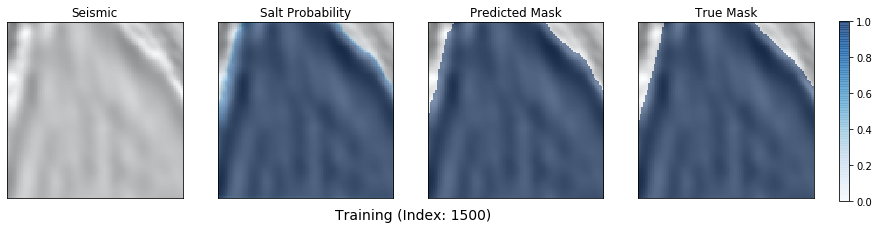

In [38]:
show_img(data_img,lb_pred_data,threshold_best,idx_img=1500)

<br>
<br>
<br>
<br>
<br>

### Prediction for test dataset

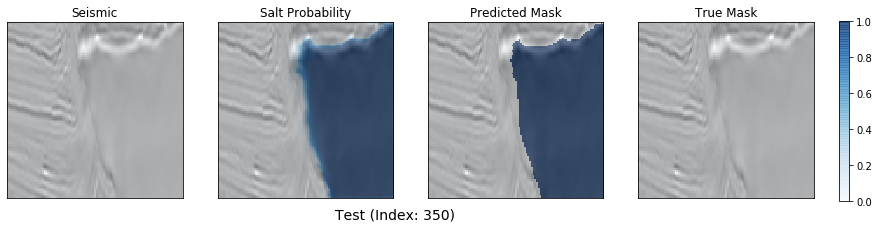

In [39]:
lb_pred_test = lb_pred_test.reshape([np.shape(test_img_up)[0],size_img**2])
show_img(test_img,lb_pred_test,threshold_best,idx_img=350,training=False)

### Output for submission

In [40]:
def output2csv(sample_submit,y_pred_test,ids_test,threshold):
    ''' Output a csv file for submission '''
    test_submit = sample_submit.copy()
    num_output = len(test_submit)
    for i in range(num_output):
        id_tmp = np.where(test_submit.id.values == ids_test[i])[0][0]
        test_submit['rle_mask'].iloc[id_tmp] = ids_output(y_pred_test[i,:],threshold)
    test_submit.to_csv('./test.csv',index=False)

In [41]:
output2csv(sample_submit,lb_pred_test,ids_test,threshold_best)